In [34]:
# Import raw data from Excel
import pandas as pd

filepath = 'C:/Users/PXY/Desktop/Orange_week.xlsx';
sheetname = 'main'
df = pd.read_excel ( filepath, sheet_name = sheetname );
print (df)

     Year    Week  Cases  Rainfalls  No.of Raindays  Max. temperature  \
0    2010   week1    NaN        NaN             NaN               NaN   
1    2010   week2    NaN        NaN             NaN               NaN   
2    2010   week3    NaN        NaN             NaN               NaN   
3    2010   week4    NaN      286.0            22.0         32.883871   
4    2010   week5    NaN        NaN             NaN               NaN   
5    2010   week6    NaN        NaN             NaN               NaN   
6    2010   week7    NaN        NaN             NaN               NaN   
7    2010   week8   36.0      241.8            11.0         34.385714   
8    2010   week9   65.0        NaN             NaN               NaN   
9    2010  week10   46.0        NaN             NaN               NaN   
10   2010  week11   31.0        NaN             NaN               NaN   
11   2010  week12   27.0      191.8            14.0         34.338710   
12   2010  week13   40.0        NaN             NaN

In [35]:
# Data preprocessing

# Set NaN to 0.0 for Cases & Fatality
df['Cases'].fillna( 0, inplace = True )
df['Fatality'].fillna(0, inplace = True )

# Set others to first found values
df['Rainfalls'].ffill( inplace = True );
df['Max. temperature'].ffill( inplace = True );
df['Min. temperature'].ffill( inplace = True );
df['Mean temp'].ffill( inplace = True );

# Ffill doesn't fill in the first three NaN, thus need to do another bfill
df['Rainfalls'].bfill( inplace = True );
df['Max. temperature'].bfill( inplace = True );
df['Min. temperature'].bfill( inplace = True );
df['Mean temp'].bfill( inplace = True );

print( df.corr() )

                      Year     Cases  Rainfalls  No.of Raindays  \
Year              1.000000  0.206160  -0.186199       -0.095696   
Cases             0.206160  1.000000   0.146976        0.109804   
Rainfalls        -0.186199  0.146976   1.000000        0.549997   
No.of Raindays   -0.095696  0.109804   0.549997        1.000000   
Max. temperature  0.118377 -0.291792  -0.385972       -0.627464   
Min. temperature  0.179053 -0.241280  -0.274385       -0.388308   
Mean temp         0.143124 -0.282314  -0.438190       -0.694038   
Fatality          0.091511  0.495949   0.114988        0.058604   

                  Max. temperature  Min. temperature  Mean temp  Fatality  
Year                      0.118377          0.179053   0.143124  0.091511  
Cases                    -0.291792         -0.241280  -0.282314  0.495949  
Rainfalls                -0.385972         -0.274385  -0.438190  0.114988  
No.of Raindays           -0.627464         -0.388308  -0.694038  0.058604  
Max. temperature

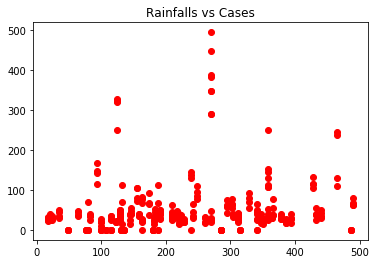

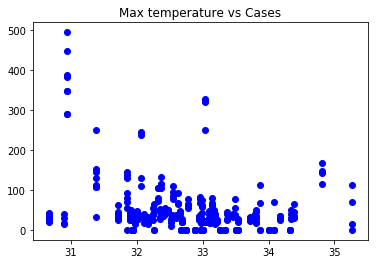

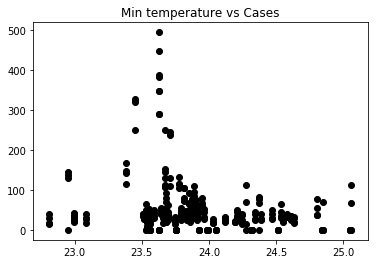

In [36]:
import numpy as np
import matplotlib.pyplot as plt
plt.scatter( df['Rainfalls'] ,df['Cases'], color="red" )
plt.title( "Rainfalls vs Cases")
plt.show()

plt.scatter( df['Max. temperature'] ,df['Cases'], color="blue" )
plt.title( "Max temperature vs Cases")
plt.show()

plt.scatter( df['Min. temperature'] ,df['Cases'], color="black" )
plt.title( "Min temperature vs Cases")
plt.show()

In [37]:
# Add new target columns
df['FatalityRate'] = (df['Fatality'] > 0).astype(int)
df['HasCase'] = (df['Cases'] > 0).astype(int)

# Drop unused columns: no.of rain days, Week, Year
if 'No.of Raindays' in df.columns:
    df = df.drop(['No.of Raindays'], axis = 1 )

if 'Year' in df.columns:
    df = df.drop(['Year'], axis = 1 )

if 'Week' in df.columns:
    df = df.drop(['Week'], axis = 1 )

if 'Fatality' in df.columns:
    df = df.drop(['Fatality'], axis = 1 )

# Since there is no case reported since 2015, drop 2015 data from time series prediction
df.drop(df.tail(52).index,inplace=True) #drop bottom 52 which is data from 2015 
    
# Verify if all the anomalies are gone
df.describe()

# Write to output csv for data visualization purpose
df.to_csv('C:/Users/PXY/Desktop/dengue.csv');

In [38]:
# Normalizing data
# This step is really useful on improving model performance
import sklearn
from sklearn.preprocessing import StandardScaler
cols_to_norm = [ 'Rainfalls','Max. temperature','Min. temperature','Mean temp']
sc = StandardScaler();
df[cols_to_norm] = sc.fit_transform(df[cols_to_norm])

# Create predictors
predictors = df.drop(['HasCase','FatalityRate', 'Cases'], axis=1).values
n_cols = predictors.shape[1] 
  
# Create target
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
target = label_encoder.fit_transform(df.HasCase)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(predictors, target, 
                                                    test_size=0.3 )

In [44]:
# Build and train the model
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf
import numpy as py
# fix random seed for reproducibility
seed = 7
py.random.seed(seed)
cvscores = []

# define 10-fold cross validation test harness
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

for train, test in kfold.split(predictors, target):
    
  # Input layer
  model = keras.Sequential() 
  model.add(layers.Dense(100, activation='relu', input_shape = (n_cols,))) 
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(100, activation='relu')) 
  model.add(layers.Dropout(0.5))

  # Output layer
  model.add(layers.Dense(1, activation='sigmoid')) 

  # Compile model
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 

  # Fit the model
  model.fit(predictors[train], target[train], epochs=40,  verbose=False )
  # evaluate the model
  scores = model.evaluate(predictors[test], target[test], verbose=0)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  cvscores.append(scores[1] * 100)

print("%.2f%% (+/- %.2f%%)" % (py.mean(cvscores), py.std(cvscores)))

acc: 92.45%
acc: 92.45%
acc: 94.23%
acc: 94.12%
acc: 94.12%
93.47% (+/- 0.84%)


In [40]:
#Define early stopping to stop training if model didn't improved for 2 epochs
from tensorflow.keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=5, monitor = 'acc')

# Input layer
model = keras.Sequential() 
model.add(layers.Dense(100, activation='relu', input_shape = (n_cols,))) 
model.add(layers.Dense(100, activation='relu')) 

# Output layer
model.add(layers.Dense(1, activation='sigmoid')) 

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 

# Fit the model
model.fit(X_train, y_train, epochs=40, verbose=1, callbacks=[early_stopping_monitor] )

# calculate accuracy
res = model.predict(X_test)
res = py.around( res, 0 ).astype(int)

import sklearn
acc = sklearn.metrics.accuracy_score( res, y_test )
print( "Predicition results from 70:30 train- test split is :", acc)

# Export result to csv
hascases = py.empty(len(df) )
hascases.fill(-1)
hascases[ len(df) - len(res):] = res.ravel()

fullresult = pd.DataFrame()
fullresult[cols_to_norm] = df[cols_to_norm]
fullresult['HasCases'] = df['HasCase']
fullresult['PredictedHasCases'] = hascases
fullresult.to_csv('C:/Users/PXY/Desktop/classifier_result.csv');

# Visualize neural network
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='C:/Users/PXY/Desktop/classifier_model.png')


Epoch 1/40
182/182 [==============================] - 0s 2ms/sample - loss: 0.6191 - acc: 0.8846
Epoch 2/40
182/182 [==============================] - 0s 170us/sample - loss: 0.4666 - acc: 0.9286
Epoch 3/40
182/182 [==============================] - 0s 148us/sample - loss: 0.3783 - acc: 0.9286
Epoch 4/40
182/182 [==============================] - 0s 148us/sample - loss: 0.3239 - acc: 0.9286
Epoch 5/40
182/182 [==============================] - 0s 132us/sample - loss: 0.2982 - acc: 0.9286
Epoch 6/40
182/182 [==============================] - 0s 137us/sample - loss: 0.2810 - acc: 0.9286
Epoch 7/40
182/182 [==============================] - 0s 139us/sample - loss: 0.2717 - acc: 0.9286
Predicition results from 70:30 train- test split is : 0.9487179487179487
